In [1]:
import numpy as np 
import pandas as pd
import pickle

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import set_config

from processing.encoders import ordinal_encode_pf, ordinal_encode_tar, onehot_encode, ordinal_encode
from processing.imputers import mf_imputer, avg_imputer
from processing.scaler import scaler
from processing.classes import Debug, UnnecessaryDelete, OutlierRemoval, FeatureEngineering, TargetTransform
from training.classes import LGBMTrain

In [2]:
# Set config to output pandas dataframe
set_config(transform_output="pandas")

In [3]:
# Pipeline to transform the target variable and remove outliers (used for the training data with other data pipeline)
pipe_data_target_outlier = make_pipeline(
    TargetTransform(),
    OutlierRemoval(),
    ColumnTransformer(
        transformers=[
            ('ordinal_encode_tar', ordinal_encode_tar, ['binaryRiskStatus']),
        ], verbose_feature_names_out=False, remainder = 'passthrough'
    )
)

In [4]:
# Pipeline to transform the features of the dataset (used alone for inference datasets)
pipe_data_feature_transform = make_pipeline(
    UnnecessaryDelete(),
    ColumnTransformer(
        transformers=[
            ('avg_impute', avg_imputer, ['loanAmount']),
            ('mf_impute', mf_imputer, 
                ['apr', 'originallyScheduledPaymentAmount', 'leadCost', 'applicationDate', 'nPaidOff',
                    'state', 'leadType', 'payFrequency', 'originated', 'approved', 'isFunded', 'hasCF']),
        ], verbose_feature_names_out=False, remainder = 'passthrough'
    ),
    FeatureEngineering(),
    ColumnTransformer(
        transformers=[
            ('scaler', scaler, ['apr', 'loanAmount', 'originallyScheduledPaymentAmount', 'lc_la_ratio']),
            ('ordinal_encode_pf', ordinal_encode_pf, ['payFrequency']),
            ('onehot_encode', onehot_encode, ['originated', 'approved', 'isFunded', 'hasCF']),
            ('ordinal_encode', ordinal_encode, ['nPaidOff', 'state', 'leadType', 'season', 'leadCost']),
        ], verbose_feature_names_out=False, remainder = 'passthrough'
    ),
)

In [5]:
# Pipeline to transform the training data
pipe_training = Pipeline([
        ('target_outlier', pipe_data_target_outlier),
        ('feature_transform', pipe_data_feature_transform),
        ('training', LGBMTrain()),
    ]
)

[LightGBM] [Info] Number of positive: 76871, number of negative: 355089
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009868 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 648
[LightGBM] [Info] Number of data points in the train set: 431960, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.177959 -> initscore=-1.530240
[LightGBM] [Info] Start training from score -1.530240


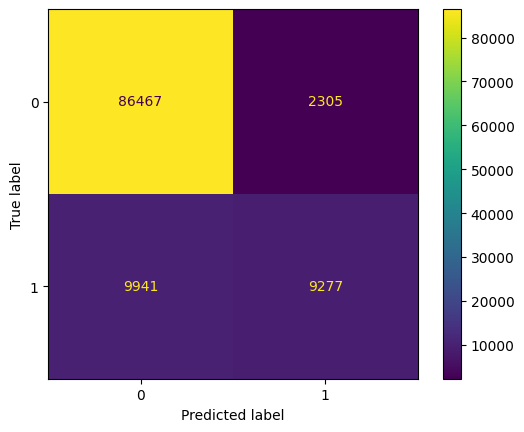

In [6]:
# Read the data and training the model
df = pd.read_csv('./data/loan.csv')

model = pipe_training.fit_transform(df)

# Saving the model in a folder
with open('./model/lgbm.pickle', 'wb') as file:
    pickle.dump(model, file, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
# Inference of 15 values
inf_df = pd.read_csv('./data/inference.csv')
inf_df = pipe_data_feature_transform.fit_transform(inf_df)

pred = model.predict(inf_df)
print(pred)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
